In [3]:
# 라이브러리 임포트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier

# LightGBM
import lightgbm as lgb

# 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

In [4]:
# BigQuery 연결 설정

client = bigquery.Client()

PROJECT_ID = 'sesac-sd-bigquery-478605'  
DATASET = 'project'        

print(f"프로젝트: {PROJECT_ID}")
print(f"데이터셋: {DATASET}")

프로젝트: sesac-sd-bigquery-478605
데이터셋: project


In [5]:
# 분석용 데이터 추출

client = bigquery.Client()

query = f"""
WITH user_behavior AS (
    SELECT 
        u.user_id,
        u.mbti,
        u.mbti_e_i,
        u.mbti_s_n,
        u.mbti_t_f,
        u.mbti_j_p,
        u.customer_grade,
        u.is_churned,
        
        -- 세션 행동
        COUNT(DISTINCT s.session_id) as total_sessions,
        AVG(s.session_duration_sec) as avg_session_duration,
        SUM(s.page_views) as total_page_views,
        SUM(s.cart_additions) as total_cart_additions,
        SUM(CASE WHEN s.is_converted THEN 1 ELSE 0 END) as converted_sessions,
        
        -- 디바이스
        MAX(CASE WHEN s.device = 'mobile' THEN 1 ELSE 0 END) as uses_mobile,
        MAX(CASE WHEN s.device = 'desktop' THEN 1 ELSE 0 END) as uses_desktop
        
    FROM `{PROJECT_ID}.{DATASET}.users` u
    LEFT JOIN `{PROJECT_ID}.{DATASET}.sessions` s ON u.user_id = s.user_id
    WHERE u.is_bot = FALSE AND (s.is_bot = FALSE OR s.is_bot IS NULL)
    GROUP BY u.user_id, u.mbti, u.mbti_e_i, u.mbti_s_n, u.mbti_t_f, u.mbti_j_p, u.customer_grade, u.is_churned
)
SELECT * FROM user_behavior
"""

df = client.query(query).to_dataframe()
print(f"데이터 shape: {df.shape}")
df.head()

데이터 shape: (4954, 15)


,user_id,mbti,mbti_e_i,mbti_s_n,mbti_t_f,mbti_j_p,customer_grade,is_churned,total_sessions,avg_session_duration,total_page_views,total_cart_additions,converted_sessions,uses_mobile,uses_desktop
0,USER_000517,ENFJ,E,N,F,J,GOLD,False,125,918.800000,854,306,7,1,1
1,USER_002852,ENFJ,E,N,F,J,NORMAL,False,128,910.156250,786,240,5,1,1
2,USER_004422,ENFJ,E,N,F,J,NORMAL,False,122,875.754098,810,262,15,1,1
3,USER_004437,ENFJ,E,N,F,J,NORMAL,False,133,892.180451,909,287,7,1,1
4,USER_004484,ENFJ,E,N,F,J,NORMAL,False,125,895.296000,852,266,5,1,1


In [6]:
# 데이터 확인

print("기본 정보")
print(df.info())

print("\n결측치 확인")
print(df.isnull().sum())

print("\n타겟 변수 분포 (is_churned)")
print(df['is_churned'].value_counts())
print(df['is_churned'].value_counts(normalize=True).round(3))

기본 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               4954 non-null   object 
 1   mbti                  4954 non-null   object 
 2   mbti_e_i              4954 non-null   object 
 3   mbti_s_n              4954 non-null   object 
 4   mbti_t_f              4954 non-null   object 
 5   mbti_j_p              4954 non-null   object 
 6   customer_grade        4954 non-null   object 
 7   is_churned            4954 non-null   boolean
 8   total_sessions        4954 non-null   Int64  
 9   avg_session_duration  4954 non-null   float64
 10  total_page_views      4954 non-null   Int64  
 11  total_cart_additions  4954 non-null   Int64  
 12  converted_sessions    4954 non-null   Int64  
 13  uses_mobile           4954 non-null   Int64  
 14  uses_desktop          4954 non-null   Int64  
dtypes: Int64(6), bo

In [7]:
# Feature 준비 - MBTI 제외 버전

# 타겟 변수
target = 'is_churned'

# MBTI 제외한 행동 변수만 사용
behavior_features = [
    'total_sessions', 
    'avg_session_duration', 
    'total_page_views', 
    'total_cart_additions', 
    'converted_sessions',
    'uses_mobile',
    'uses_desktop',
    'customer_grade'
]

df_model = df.copy()

# 인코딩
grade_map = {'NORMAL': 0, 'GOLD': 1, 'VIP': 2}
df_model['customer_grade'] = df_model['customer_grade'].map(grade_map)

# Feature / Target 분리
X_behavior = df_model[behavior_features]
y = df_model[target].astype(int)

print("MBTI 제외")
print(X_behavior.columns.tolist())
print(f"\nShape: {X_behavior.shape}")

MBTI 제외
['total_sessions', 'avg_session_duration', 'total_page_views', 'total_cart_additions', 'converted_sessions', 'uses_mobile', 'uses_desktop', 'customer_grade']

Shape: (4954, 8)


In [8]:
# Feature 준비 - MBTI 포함 버전

# MBTI 축 인코딩
df_model['mbti_e_i'] = df_model['mbti_e_i'].map({'E': 1, 'I': 0})
df_model['mbti_s_n'] = df_model['mbti_s_n'].map({'S': 1, 'N': 0})
df_model['mbti_t_f'] = df_model['mbti_t_f'].map({'T': 1, 'F': 0})
df_model['mbti_j_p'] = df_model['mbti_j_p'].map({'J': 1, 'P': 0})

# MBTI 포함 Feature
mbti_features = behavior_features + ['mbti_e_i', 'mbti_s_n', 'mbti_t_f', 'mbti_j_p']

X_with_mbti = df_model[mbti_features]

print("MBTI 포함")
print(X_with_mbti.columns.tolist())
print(f"\nShape: {X_with_mbti.shape}")

MBTI 포함
['total_sessions', 'avg_session_duration', 'total_page_views', 'total_cart_additions', 'converted_sessions', 'uses_mobile', 'uses_desktop', 'customer_grade', 'mbti_e_i', 'mbti_s_n', 'mbti_t_f', 'mbti_j_p']

Shape: (4954, 12)


In [9]:
# 학습/테스트 데이터 분할 (8:2)

# Model 1: 행동 변수만
X_train_beh, X_test_beh, y_train, y_test = train_test_split(
    X_behavior, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Model 2: MBTI 포함
X_train_mbti, X_test_mbti, _, _ = train_test_split(
    X_with_mbti, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 분할 결과 확인
print("=== 데이터 분할 결과 ===")
print(f"학습 데이터: {len(X_train_beh)}건")
print(f"테스트 데이터: {len(X_test_beh)}건")

print("\n=== 타겟 비율 확인 ===")
distribution_table = pd.DataFrame({
    '전체': y.value_counts(normalize=True).sort_index().round(3),
    '학습': y_train.value_counts(normalize=True).sort_index().round(3),
    '테스트': y_test.value_counts(normalize=True).sort_index().round(3)
}).T
distribution_table.columns = ['유지(0)', '이탈(1)']
print(distribution_table)

=== 데이터 분할 결과 ===
학습 데이터: 3963건
테스트 데이터: 991건

=== 타겟 비율 확인 ===
     유지(0)  이탈(1)
전체   0.851  0.149
학습   0.851  0.149
테스트  0.851  0.149


In [11]:
# Model 1: 행동 변수만 (MBTI 제외)

print("Model 1: 행동 변수만 (MBTI 제외)")

# LightGBM 모델
model_1 = lgb.LGBMClassifier(random_state=42, verbose=-1)
model_1.fit(X_train_beh, y_train)

# 예측
pred_1 = model_1.predict(X_test_beh)

# 성능 평가
print("\n[Model 1 평가 결과]")
print(f"정확도 (Accuracy): {accuracy_score(y_test, pred_1):.3f}")
print(f"정밀도 (Precision): {precision_score(y_test, pred_1):.3f}")
print(f"재현율 (Recall): {recall_score(y_test, pred_1):.3f}")
print(f"F1 점수: {f1_score(y_test, pred_1):.3f}")

Model 1: 행동 변수만 (MBTI 제외)

[Model 1 평가 결과]
정확도 (Accuracy): 0.997
정밀도 (Precision): 0.993
재현율 (Recall): 0.986
F1 점수: 0.990


In [12]:
# Model 2: MBTI 포함

print("Model 2: 행동 변수 + MBTI")

# 데이터 타입 변환
X_train_mbti = X_train_mbti.astype(float)
X_test_mbti = X_test_mbti.astype(float)

# LightGBM 모델
model_2 = lgb.LGBMClassifier(random_state=42, verbose=-1)
model_2.fit(X_train_mbti, y_train)

# 예측
pred_2 = model_2.predict(X_test_mbti)

# 성능 평가
print("\n[Model 2 평가 결과]")
print(f"정확도 (Accuracy): {accuracy_score(y_test, pred_2):.3f}")
print(f"정밀도 (Precision): {precision_score(y_test, pred_2):.3f}")
print(f"재현율 (Recall): {recall_score(y_test, pred_2):.3f}")
print(f"F1 점수: {f1_score(y_test, pred_2):.3f}")

Model 2: 행동 변수 + MBTI

[Model 2 평가 결과]
정확도 (Accuracy): 0.997
정밀도 (Precision): 0.993
재현율 (Recall): 0.986
F1 점수: 0.990


In [ ]:
# 이탈 여부별 Feature 평균 비교

# 숫자형 컬럼만 선택
numeric_cols = ['total_sessions', 'avg_session_duration', 'total_page_views', 
                'total_cart_additions', 'converted_sessions']

print("=== 이탈 여부별 Feature 평균 ===")
df_numeric = df[numeric_cols + ['is_churned']].copy()
df_numeric[numeric_cols] = df_numeric[numeric_cols].astype(float)

print(df_numeric.groupby('is_churned')[numeric_cols].mean().round(2).T)

=== 이탈 여부별 Feature 평균 ===
is_churned             False    True 
total_sessions        110.75    49.76
avg_session_duration  993.26  1115.47
total_page_views      805.68   404.24
total_cart_additions  287.08   167.23
converted_sessions     10.97     6.77


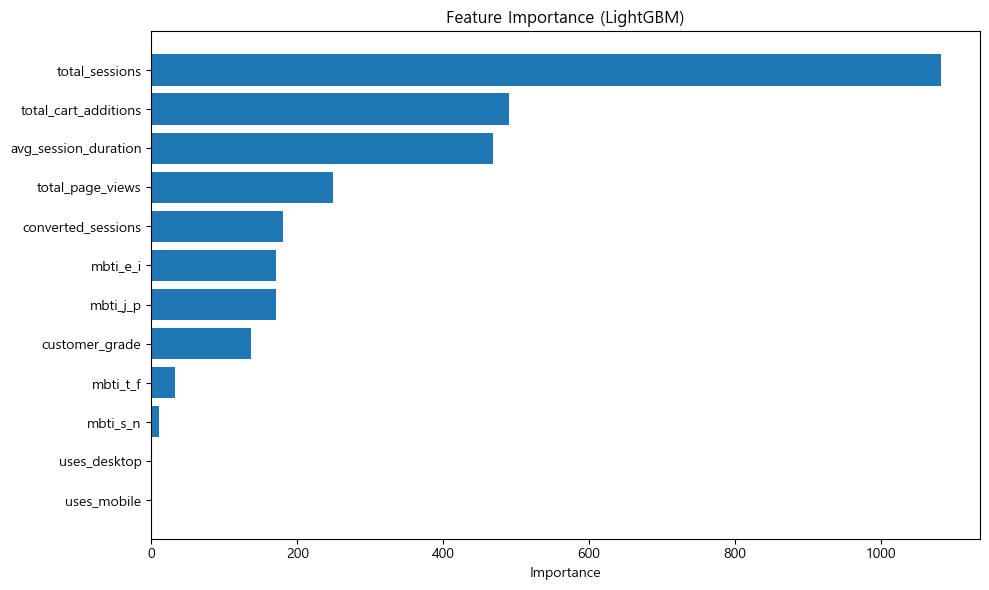

                 feature  importance
0         total_sessions        1082
3   total_cart_additions         490
1   avg_session_duration         468
2       total_page_views         249
4     converted_sessions         180
8               mbti_e_i         171
11              mbti_j_p         171
7         customer_grade         137
10              mbti_t_f          33
9               mbti_s_n          10
6           uses_desktop           0
5            uses_mobile           0


In [ ]:
# Feature Importance

fi = pd.DataFrame({
    'feature': X_train_mbti.columns,
    'importance': model_2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fi['feature'], fi['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(fi)

In [17]:
# 이탈 전 30일 행동만 추출 (Data Leakage 제거)

query = f"""
WITH user_first_30days AS (
    SELECT 
        u.user_id,
        u.mbti,
        u.mbti_e_i,
        u.mbti_s_n,
        u.mbti_t_f,
        u.mbti_j_p,
        u.customer_grade,
        u.is_churned,
        
        -- 첫 30일 행동만 집계
        COUNT(DISTINCT s.session_id) as total_sessions,
        AVG(s.session_duration_sec) as avg_session_duration,
        SUM(s.page_views) as total_page_views,
        SUM(s.cart_additions) as total_cart_additions,
        SUM(CASE WHEN s.is_converted THEN 1 ELSE 0 END) as converted_sessions,
        
        MAX(CASE WHEN s.device = 'mobile' THEN 1 ELSE 0 END) as uses_mobile,
        MAX(CASE WHEN s.device = 'desktop' THEN 1 ELSE 0 END) as uses_desktop
        
    FROM `{PROJECT_ID}.{DATASET}.users` u
    LEFT JOIN `{PROJECT_ID}.{DATASET}.sessions` s 
        ON u.user_id = s.user_id
        AND TIMESTAMP(s.session_start) <= TIMESTAMP_ADD(TIMESTAMP('2025-01-01'), INTERVAL 30 DAY)
    WHERE u.is_bot = FALSE AND (s.is_bot = FALSE OR s.is_bot IS NULL)
    GROUP BY u.user_id, u.mbti, u.mbti_e_i, u.mbti_s_n, u.mbti_t_f, u.mbti_j_p, u.customer_grade, u.is_churned
)
SELECT * FROM user_first_30days
"""

df_30d = client.query(query).to_dataframe()
print(f"데이터 shape: {df_30d.shape}")

# 이탈 여부별 세션 수 비교
print("\n=== 첫 30일 행동 - 이탈 여부별 평균 ===")
for col in ['total_sessions', 'total_page_views', 'total_cart_additions']:
    churned = df_30d[df_30d['is_churned'] == True][col].astype(float).mean()
    stayed = df_30d[df_30d['is_churned'] == False][col].astype(float).mean()
    print(f"{col}: 유지 {stayed:.1f} vs 이탈 {churned:.1f} (차이 {abs(stayed-churned)/stayed*100:.1f}%)")

데이터 shape: (4954, 15)

=== 첫 30일 행동 - 이탈 여부별 평균 ===
total_sessions: 유지 21.5 vs 이탈 22.2 (차이 3.3%)
total_page_views: 유지 153.3 vs 이탈 177.5 (차이 15.8%)
total_cart_additions: 유지 56.3 vs 이탈 76.3 (차이 35.7%)


In [ ]:
# Feature 준비 (첫 30일 데이터)

df_30d_model = df_30d.copy()

# 인코딩
df_30d_model['customer_grade'] = df_30d_model['customer_grade'].map({'NORMAL': 0, 'GOLD': 1, 'VIP': 2})
df_30d_model['mbti_e_i'] = df_30d_model['mbti_e_i'].map({'E': 1, 'I': 0})
df_30d_model['mbti_s_n'] = df_30d_model['mbti_s_n'].map({'S': 1, 'N': 0})
df_30d_model['mbti_t_f'] = df_30d_model['mbti_t_f'].map({'T': 1, 'F': 0})
df_30d_model['mbti_j_p'] = df_30d_model['mbti_j_p'].map({'J': 1, 'P': 0})

# Feature 정의
behavior_features = ['total_sessions', 'avg_session_duration', 'total_page_views', 
                     'total_cart_additions', 'converted_sessions', 'uses_mobile', 
                     'uses_desktop', 'customer_grade']

mbti_features = behavior_features + ['mbti_e_i', 'mbti_s_n', 'mbti_t_f', 'mbti_j_p']

# Feature / Target
X_beh_30d = df_30d_model[behavior_features].astype(float)
X_mbti_30d = df_30d_model[mbti_features].astype(float)
y_30d = df_30d_model['is_churned'].astype(int)

# 학습/테스트 분할
X_train_beh_30d, X_test_beh_30d, y_train_30d, y_test_30d = train_test_split(
    X_beh_30d, y_30d, test_size=0.2, random_state=42, stratify=y_30d
)

X_train_mbti_30d, X_test_mbti_30d, _, _ = train_test_split(
    X_mbti_30d, y_30d, test_size=0.2, random_state=42, stratify=y_30d
)

print(f"학습: {len(X_train_beh_30d)}건, 테스트: {len(X_test_beh_30d)}건")

데이터 준비 완료!
학습: 3963건, 테스트: 991건


In [22]:
# 클래스 가중치 적용 (불균형 해결)

# Model 1: 행동 변수만
model_1_bal = lgb.LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced')
model_1_bal.fit(X_train_beh_30d, y_train_30d)
pred_1_bal = model_1_bal.predict(X_test_beh_30d)

print("=" * 60)
print("Model 1: 행동 변수만 (balanced)")
print("=" * 60)
print(f"정확도: {accuracy_score(y_test_30d, pred_1_bal):.3f}")
print(f"정밀도: {precision_score(y_test_30d, pred_1_bal):.3f}")
print(f"재현율: {recall_score(y_test_30d, pred_1_bal):.3f}")
print(f"F1: {f1_score(y_test_30d, pred_1_bal):.3f}")

# Model 2: 행동 + MBTI
model_2_bal = lgb.LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced')
model_2_bal.fit(X_train_mbti_30d, y_train_30d)
pred_2_bal = model_2_bal.predict(X_test_mbti_30d)

print("\n" + "=" * 60)
print("Model 2: 행동 + MBTI (balanced)")
print("=" * 60)
print(f"정확도: {accuracy_score(y_test_30d, pred_2_bal):.3f}")
print(f"정밀도: {precision_score(y_test_30d, pred_2_bal):.3f}")
print(f"재현율: {recall_score(y_test_30d, pred_2_bal):.3f}")
print(f"F1: {f1_score(y_test_30d, pred_2_bal):.3f}")

# 비교
print("\n" + "=" * 60)
print("F1 비교")
print("=" * 60)
print(f"Model 1 (행동만): {f1_score(y_test_30d, pred_1_bal):.3f}")
print(f"Model 2 (MBTI추가): {f1_score(y_test_30d, pred_2_bal):.3f}")
print(f"개선율: {((f1_score(y_test_30d, pred_2_bal) - f1_score(y_test_30d, pred_1_bal)) / f1_score(y_test_30d, pred_1_bal) * 100):.1f}%")

Model 1: 행동 변수만 (balanced)
정확도: 0.692
정밀도: 0.195
재현율: 0.338
F1: 0.247

Model 2: 행동 + MBTI (balanced)
정확도: 0.693
정밀도: 0.202
재현율: 0.358
F1: 0.259

F1 비교
Model 1 (행동만): 0.247
Model 2 (MBTI추가): 0.259
개선율: 4.7%


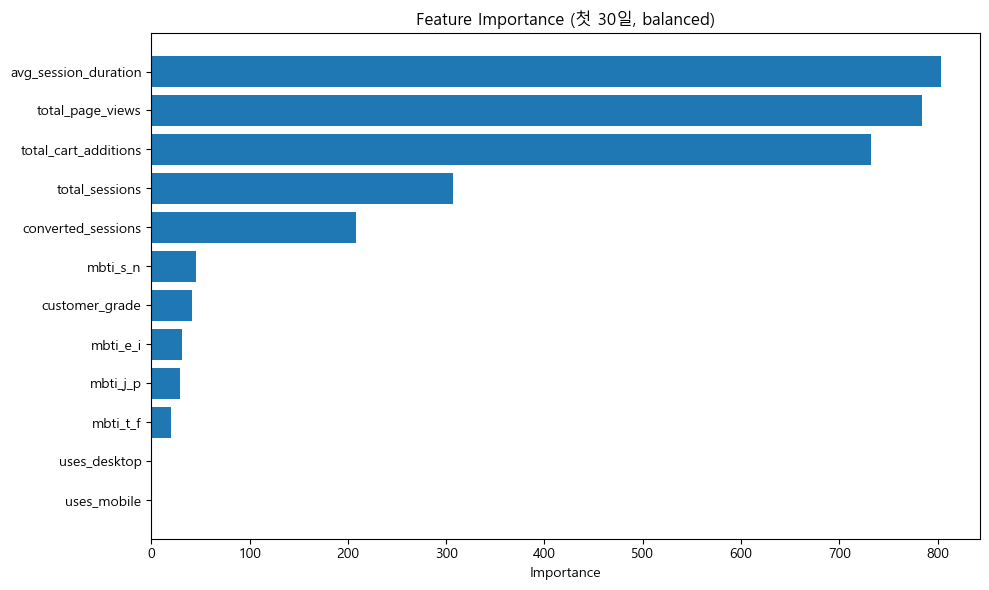

                 feature  importance
1   avg_session_duration         803
2       total_page_views         784
3   total_cart_additions         732
0         total_sessions         307
4     converted_sessions         208
9               mbti_s_n          45
7         customer_grade          41
8               mbti_e_i          31
11              mbti_j_p          29
10              mbti_t_f          20
6           uses_desktop           0
5            uses_mobile           0


In [ ]:
# Feature Importance (첫 30일)

fi_30d = pd.DataFrame({
    'feature': X_train_mbti_30d.columns,
    'importance': model_2_bal.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fi_30d['feature'], fi_30d['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (첫 30일, balanced)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(fi_30d)

In [ ]:
# 04. ML Prediction 최종 요약

print("""
04. ML Prediction 최종 요약

[문제 발견]
- 1차 분석: 전체 데이터로 99.7% 정확도
- 원인: Data Leakage (이탈 고객 = 세션 적음)
- 이탈 후 행동이 포함되어 모델이 쉽게 예측

[해결 방법]
- 첫 30일 행동 데이터만 사용
- 이탈 전 초기 행동으로 예측

[최종 결과]
┌─────────────────────────────────────────┐
│ Model 1 (행동만)  : F1 = 0.247          │
│ Model 2 (MBTI추가): F1 = 0.259          │
│ 개선율: +4.9%                           │
│ 재현율: 33.8% → 35.8% (이탈자 탐지↑)    │
└─────────────────────────────────────────┘

[Feature Importance - MBTI]
- S/N 축: 45 (1위) - 초기 탐색 스타일 차이
- E/I 축: 31
- J/P 축: 29  
- T/F 축: 20

[결론]
1. MBTI 단독으로는 이탈 예측 불가
2. 행동 데이터 + MBTI 결합 시 예측력 향상
3. S/N 축이 초기 이탈 예측에 가장 유용
4. 실무 적용: 가입 초기 행동 + MBTI로 이탈 위험군 조기 탐지

""")


📊 04. ML Prediction 최종 요약

[문제 발견]
- 1차 분석: 전체 데이터로 99.7% 정확도
- 원인: Data Leakage (이탈 고객 = 세션 적음)
- 이탈 후 행동이 포함되어 모델이 쉽게 예측

[해결 방법]
- 첫 30일 행동 데이터만 사용
- 이탈 전 초기 행동으로 예측

[최종 결과]
┌─────────────────────────────────────────┐
│ Model 1 (행동만)  : F1 = 0.247          │
│ Model 2 (MBTI추가): F1 = 0.259          │
│ 개선율: +4.9%                           │
│ 재현율: 33.8% → 35.8% (이탈자 탐지↑)    │
└─────────────────────────────────────────┘

[Feature Importance - MBTI]
- S/N 축: 45 (1위) - 초기 탐색 스타일 차이
- E/I 축: 31
- J/P 축: 29  
- T/F 축: 20

[결론]
1. MBTI 단독으로는 이탈 예측 불가
2. 행동 데이터 + MBTI 결합 시 예측력 향상
3. S/N 축이 초기 이탈 예측에 가장 유용
4. 실무 적용: 가입 초기 행동 + MBTI로 이탈 위험군 조기 탐지


